# DAT210x - Programming with Python for DS

## Module5- Lab4

In [157]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# You might need to import more modules here..
# .. your code here ..

matplotlib.style.use('ggplot') # Look Pretty
c = ['red', 'green', 'blue', 'orange', 'yellow', 'brown']

You can experiment with these parameters:

In [158]:
PLOT_TYPE_TEXT = False    # If you'd like to see indices
PLOT_VECTORS = True       # If you'd like to see your original features in P.C.-Space

### Some Convenience Functions

In [159]:
def drawVectors(transformed_features, components_, columns, plt):
    num_columns = len(columns)

    # This function will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ## Visualize projections

    # Sort each column by its length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Projected Features by importance:\n", important_features)

    ax = plt.axes()

    for i in range(num_columns):
        # Use an arrow to project each original feature as a
        # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75, zorder=600000)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75, zorder=600000)
        
    return ax

In [160]:
def doPCA(data, dimensions=2):
    model = PCA(n_components=dimensions, svd_solver='randomized', random_state=7)
    model.fit(data)
    return model

In [161]:
def doKMeans(data, num_clusters=0):
    # TODO: Do the KMeans clustering here, passing in the # of clusters parameter
    # and fit it against your data. Then, return a tuple containing the cluster
    # centers and the labels.
    #
    # Hint: Just like with doPCA above, you will have to create a variable called
    # `model`, which will be a SKLearn K-Means model for this to work.
    
    model = KMeans(n_clusters = num_clusters)
    model.fit(data)
    labels = model.predict(data)
    #labels = model.fit_predict(data)
    
    return model.cluster_centers_, model.labels_

Load up the dataset. It may or may not have nans in it. Make sure you catch them and destroy them, by setting them to `0`. This is valid for this dataset, since if the value is missing, you can assume no money was spent on it.

In [181]:
df = pd.read_csv("Datasets/Wholesale customers data.csv", header = 0, na_values = 0)
df.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [163]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [164]:
df.shape

(440, 8)

As instructed, get rid of the `Channel` and `Region` columns, since you'll be investigating as if this were a single location wholesaler, rather than a national / international one. Leaving these fields in here would cause KMeans to examine and give weight to them:

In [182]:
df = df.drop(labels = ["Channel","Region"], axis = 1)
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [166]:
df.shape

(440, 6)

Before unitizing / standardizing / normalizing your data in preparation for K-Means, it's a good idea to get a quick peek at it. You can do this using the `.describe()` method, or even by using the built-in pandas `df.plot.hist()`:

In [167]:
df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


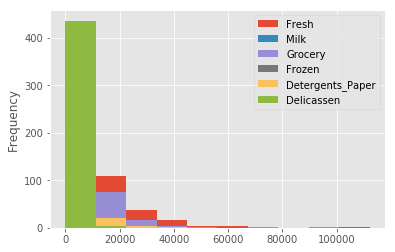

In [168]:
df.plot.hist()
plt.show()

Having checked out your data, you may have noticed there's a pretty big gap between the top customers in each feature category and the rest. Some feature scaling algorithms won't get rid of outliers for you, so it's a good idea to handle that manually---particularly if your goal is NOT to determine the top customers. 

After all, you can do that with a simple Pandas `.sort_values()` and not a machine learning clustering algorithm. From a business perspective, you're probably more interested in clustering your +/- 2 standard deviation customers, rather than the top and bottom customers.

Remove top 5 and bottom 5 samples for each column:

In [183]:
drop = {}
for col in df.columns:
    # Bottom 5
    sort = df.sort_values(by=col, ascending=True)
    if len(sort) > 5: sort=sort[:5]
    for index in sort.index: drop[index] = True # Just store the index once

    # Top 5
    sort = df.sort_values(by=col, ascending=False)
    if len(sort) > 5: sort=sort[:5]
    for index in sort.index: drop[index] = True # Just store the index once

Drop rows by index. We do this all at once in case there is a collision. This way, we don't end up dropping more rows than we have to, if there is a single row that satisfies the drop for multiple columns. Since there are 6 rows, if we end up dropping < 5*6*2 = 60 rows, that means there indeed were collisions:

In [184]:
print("Dropping {0} Outliers...".format(len(drop)))
df.drop(inplace=True, labels=drop.keys(), axis=0)
df.describe()

Dropping 42 Outliers...


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,10996.231156,5144.090452,7091.711055,2639.721106,2562.974874,1278.736181
std,9933.042596,5057.406574,6923.019293,2974.246906,3608.176776,1220.745297
min,37.000000,258.000000,314.000000,47.000000,10.000000,11.000000
25%,3324.500000,1571.250000,2155.500000,749.750000,273.250000,409.500000
50%,8257.500000,3607.500000,4573.000000,1526.000000,812.000000,946.500000
75%,15828.500000,6953.250000,9922.250000,3370.250000,3841.500000,1752.250000
max,53205.000000,29892.000000,39694.000000,17866.000000,19410.000000,7844.000000


### What are you interested in?

In [171]:
df.shape

(398, 6)

Depending on what you're interested in, you might take a different approach to normalizing/standardizing your data.
 
You should note that all columns left in the dataset are of the same unit. You might ask yourself, do I even need to normalize / standardize the data? The answer depends on what you're trying to accomplish. For instance, although all the units are the same (generic money unit), the price per item in your store isn't. There may be some cheap items and some expensive one. If your goal is to find out what items people tend to buy together but you didn't  "unitize" properly before running kMeans, the contribution of the lesser priced item would be dwarfed by the more expensive item. This is an issue of scale.

For a great overview on a few of the normalization methods supported in SKLearn, please check out: https://stackoverflow.com/questions/30918781/right-function-for-normalizing-input-of-sklearn-svm

Suffice to say, at the end of the day, you're going to have to know what question you want answered and what data you have available in order to select the best method for your purpose. Luckily, SKLearn's interfaces are easy to switch out so in the mean time, you can experiment with all of them and see how they alter your results.

5-sec summary before you dive deeper online:

### Normalization

Let's say your user spend a LOT. Normalization divides each item by the average overall amount of spending. Stated differently, your new feature is = the contribution of overall spending going into that particular item: \$spent on feature / \$overall spent by sample.

### MinMax

What % in the overall range of $spent by all users on THIS particular feature is the current sample's feature at? When you're dealing with all the same units, this will produce a near face-value amount. Be careful though: if you have even a single outlier, it can cause all your data to get squashed up in lower percentages.

Imagine your buyers usually spend \$100 on wholesale milk, but today only spent \$20. This is the relationship you're trying to capture with MinMax. NOTE: MinMax doesn't standardize (std. dev.); it only normalizes / unitizes your feature, in the mathematical sense. MinMax can be used as an alternative to zero mean, unit variance scaling. [(sampleFeatureValue-min) / (max-min)] * (max-min) + min Where min and max are for the overall feature values for all samples.

### Back to The Assignment

Un-comment just ***ONE*** of lines at a time and see how alters your results. Pay attention to the direction of the arrows, as well as their LENGTHS:

In [172]:
T = preprocessing.StandardScaler().fit_transform(df)
#T = preprocessing.MinMaxScaler().fit_transform(df)
#T = preprocessing.MaxAbsScaler().fit_transform(df)
#T = preprocessing.Normalizer().fit_transform(df)
#T = df # No Change

Sometimes people perform PCA before doing KMeans, so that KMeans only operates on the most meaningful features. In our case, there are so few features that doing PCA ahead of time isn't really necessary, and you can do KMeans in feature space. But keep in mind you have the option to transform your data to bring down its dimensionality. If you take that route, then your Clusters will already be in PCA-transformed feature space, and you won't have to project them again for visualization.

In [173]:
# Do KMeans

n_clusters = 3
centroids, labels = doKMeans(T, n_clusters)

Print out your centroids. They're currently in feature-space, which is good. Print them out before you transform them into PCA space for viewing

In [174]:
print(centroids)

[[ 1.20725644 -0.12927099 -0.31707856  1.08169261 -0.45400669  0.59174102]
 [-0.26232459 -0.41632038 -0.43893222 -0.29733807 -0.38963897 -0.32590196]
 [-0.56995352  1.31744707  1.58541223 -0.33454978  1.59481374  0.27849802]]


Now that we've clustered our KMeans, let's do PCA, using it as a tool to visualize the results. Project the centroids as well as the samples into the new 2D feature space for visualization purposes:

In [175]:
display_pca = doPCA(T)
T = display_pca.transform(T)
CC = display_pca.transform(centroids)

Visualize all the samples. Give them the color of their cluster label

In [176]:
fig = plt.figure()
ax = fig.add_subplot(111)
if PLOT_TYPE_TEXT:
    # Plot the index of the sample, so you can further investigate it in your dset
    for i in range(len(T)): ax.text(T[i,0], T[i,1], df.index[i], color=c[labels[i]], alpha=0.75, zorder=600000)
    ax.set_xlim(min(T[:,0])*1.2, max(T[:,0])*1.2)
    ax.set_ylim(min(T[:,1])*1.2, max(T[:,1])*1.2)
else:
    # Plot a regular scatter plot
    sample_colors = [ c[labels[i]] for i in range(len(T)) ]
    ax.scatter(T[:, 0], T[:, 1], c=sample_colors, marker='o', alpha=0.2)

Plot the Centroids as X's, and label them

In [177]:
ax.scatter(CC[:, 0], CC[:, 1], marker='x', s=169, linewidths=3, zorder=1000, c=c)
for i in range(len(centroids)):
    ax.text(CC[i, 0], CC[i, 1], str(i), zorder=500010, fontsize=18, color=c[i])

In [178]:
# Display feature vectors for investigation:
if PLOT_VECTORS:
    drawVectors(T, display_pca.components_, df.columns, plt)

Projected Features by importance:
 [(4.439422524289905, 'Grocery'), (4.3521532757037855, 'Detergents_Paper'), (4.209841269791213, 'Milk'), (2.9463403053237607, 'Delicassen'), (2.696521417365536, 'Fresh'), (2.6383798432550787, 'Frozen')]


C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [179]:
# Add the cluster label back into the dataframe and display it:
df['label'] = pd.Series(labels, index=df.index)
#df

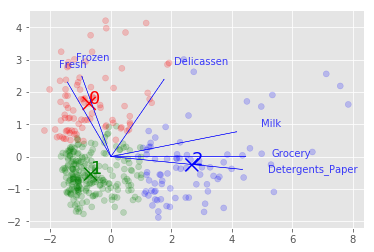

In [180]:
plt.show()#preprocessing.StandardScaler()

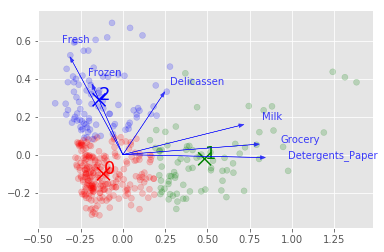

In [156]:
plt.show()#preprocessing.MinMaxScaler()

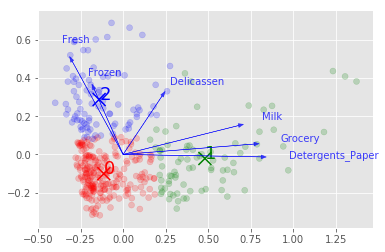

In [132]:
plt.show()#preprocessing.MaxAbsScaler()

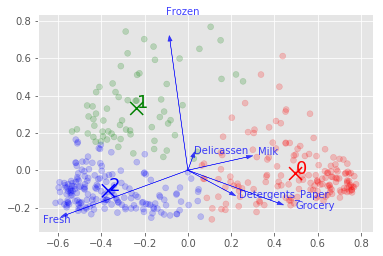

In [84]:
plt.show()#preprocessing.Normalizer()

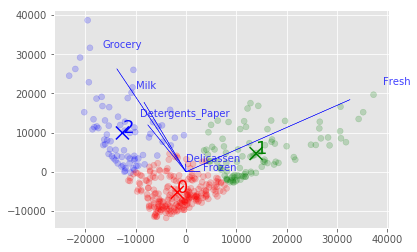

In [39]:
plt.show()#No diiference

Q). 
I found several questions related to this, but no one solved my doubts. In particular, the two answers to this question confused me even more.
I'm training a linear SVM on top of a set of features - Convolutional Neural Net features resulting from images. I have, for example, a 3500x4096 X matrix with examples on rows and features on columns, as usual.
I'm wondering how to properly standardize/normalize this matrix before feeding the SVM. I see two ways (using sklearn):
Standardizing features. It results in features with 0 mean and unitary std.
X = sklearn.preprocessing.scale(X)
Normalizing features. It results in features with unitary norm.
X = sklearn.preprocessing.normalize(X, axis=0)
My results are sensibly better with normalization (76% accuracy) than with standardiing (68% accuracy).

SOl.:

Basic diifference when to normalize or scale or use mim-max scaler:

You should choose the scaling scheme based on what makes sense with your data. There are different ways of scaling, and which one you'll use depends on the data. Each scheme brings values of different features into comparable ranges, but each of them preserve different types of information (and distort others) as they do so. And even though there are rational explanations behind why some scaling schemes are better suited for a specific case, there is nothing wrong with just trying these different ones (like you did with standard scaling and normalization) and using the one that works better (as long as you cross-validate or otherwise make sure that your performance measurement is general and accurate).
StandardScaler
This is what sklearn.preprocessing.scale(X) uses. It assumes that your features are normally distributed (each feature with a different mean and standard deviation), and scales them such that each feature's Gaussian distribution is now centered around 0 and it's standard deviation is 1.
It does this by calculating the mean and stdev for each feature, then converts each actual value for the feature into a z-score: how many stdevs away from the mean is this value? z=(value-mean)/stdev
This quite often works well but if the normality assumption is completely wrong for your case, then this may not be the best scaling scheme for you. Practically, in many cases where the normality assumption does not hold, but the distributions are somewhat close, this scheme still works pretty well. However, if the data is completely far away from normality, for example highly skewed, fat-tailed distributions (like a power-law), this scheme will not give good results.
Normalizer
This is what sklearn.preprocessing.normalize(X, axis=0) uses. It looks at all the feature values for a given data point as a vector and normalizes that vector by dividing it by it's magnitude. For example, let's say you have 3 features. The values for a specific point are [x1, x2, x3]. If you're using the default 'l2' normalization, you divide each value by sqrt(x1^2 + x2^2 + x3^2). If you're using 'l1' normalization, you divide each by x1+x2+x3. This makes sure that the values are in similar ranges for each feature, since each feature vector is a unit vector. If feature values for a point are large, so is the magnitude and you divide by a large number. If they are small, you divide them by a small number.
The reasoning is that you can think of your data as points in an n-dimensional space, where n is the number of features. Each feature is an axis. Normalization pulls each point back to the origin in a way that it is only 1 unit distant from the origin. Basically you collapse the space into the unit hypercube. The angles between the vectors for each point (from the origin to the data point) stay the same.
This is used a lot with text data, since it makes a lot of intuitive sense there: If each feature is the count of a different word, 'l1' normalization basically converts those counts to frequencies (you're dividing by the total count of words). This makes sense. If you're using 'l2' normalization, the angle between two vectors (this is called the cosine distance or similarity) will stay the same when you normalize both, and this distance is closer to a meaning distance since it corresponds to ratios of frequencies between words and is not affected by how long of a text each vector represents.
If conserving a cosine distance type of relationship between points is what makes more sense for your data, or if normalization corresponds to a natural scaling (like taking frequencies instead of counts), then this one is more suitable.
MinMaxScaler
You can use this one like sklearn.preprocessing.MinMaxScaler().fit_transform(X). For each feature, this looks at the minimum and maximum value. This is the range of this feature. Then it shrinks or stretches this to the same range for each feature (the default is 0 to 1).
It does this by converting each value to (value-feature_min)/(feature_max - feature_min). It is basically at what percentage of the range am I lying? Remember that the range is only determined by the min and max for the feature. For all this cares, all values might be hanging around 10, 11, or so, and there is a single outlier that's 900. Doesn't matter, your range is 10 to 900. You can see that in some cases that's desirable, and in others this will be problematic, depending on the specific problem and data.
This scheme works much better in certain cases where StandardScaler might not work well. For example, if the standard deviations are very small for features, StandardScaler is highly sensitive to tiny changes between standard deviations of different features, but MinMaxScaler is very robust. Also, for features with highly skewed distributions, or sparse cases where each feature has a lot of zeros that moves the distribution away from a Gaussian, MinMaxScaler is a better choice.

Standard scaling
[[-0.26232459 -0.41632038 -0.43893222 -0.29733807 -0.38963897 -0.32590196]
 [ 1.20725644 -0.12927099 -0.31707856  1.08169261 -0.45400669  0.59174102]
 [-0.56995352  1.31744707  1.58541223 -0.33454978  1.59481374  0.27849802]]
Projected Features by importance:
 [(4.439422524289905, 'Grocery'), (4.3521532757037855, 'Detergents_Paper'), (4.209841269791213, 'Milk'), (2.9463403053237607, 'Delicassen'), (2.696521417365536, 'Fresh'), (2.6383798432550787, 'Frozen')]
MinMaxScaling
[[ 0.14914954  0.09229439  0.09416618  0.10908173  0.05869795  0.11206777]
 [ 0.45936822  0.15021849  0.12135719  0.29261998  0.05082     0.25496023]
 [ 0.0952375   0.39042148  0.45236891  0.09068059  0.42993621  0.20431667]]


C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Projected Features by importance:
 [(0.8132167413999436, 'Detergents_Paper'), (0.7788400034858011, 'Grocery'), (0.7032099902181784, 'Milk'), (0.5728984770990655, 'Fresh'), (0.38544596612163495, 'Frozen'), (0.384325329127393, 'Delicassen')]
Absolute max scaling
[[ 0.14974124  0.10012886  0.10133179  0.11142546  0.05918291  0.11331296]
 [ 0.09586669  0.39568279  0.45670095  0.09307274  0.43022991  0.2054325 ]
 [ 0.45974419  0.15755301  0.1283077   0.29448088  0.05130902  0.25600503]]
Projected Features by importance:
 [(0.8121011097147013, 'Detergents_Paper'), (0.7714690347496131, 'Grocery'), (0.6953583197149135, 'Milk'), (0.5722406871030541, 'Fresh'), (0.38261014861949616, 'Delicassen'), (0.3823034907163372, 'Frozen')]
Normalizing
[[ 0.2684144   0.49388307  0.67048633  0.10898233  0.26452767  0.10321558]
 [ 0.91490404  0.17014669  0.23558699  0.11841346  0.05372885  0.06762991]
 [ 0.70396565  0.21617475  0.24861446  0.53128123  0.05030055  0.09765876]]
Projected Features by importance:


[]